# Theresia - Capstone Project

## The News Classifier: Leveraging Machine Learning to Categorize Headlines¶

Dataset: https://www.kaggle.com/datasets/rmisra/news-category-dataset

Source: Huffington Post

The aim of this project is to classify news headlines into it's topic categories.

The data came from HuffPost’s website and accessed through Kaggle collected between 2012 to 2022 (Misra, 2022). The dataset contains 209,527 rows and 6 columns (link, headline, category, short_description, authors, date). The dataset had some content imbalances, where there are 200,000 headlines between 2012 and May 2018, and only 10,000 headlines between May 2018 and 2022. 

### Import libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV

import joblib
from sklearn.base import BaseEstimator, TransformerMixin
import streamlit as st

import warnings
warnings.filterwarnings('ignore')

In [ ]:
news = pd.read_csv('news_dataset.csv')

In [ ]:
news.head()

,link,headline,category,short_description,authors,date,encoded_category,tokenized_headline,tokenized_description,char_count,...,uppercase_count,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count,year,month
0,https://www.huffingtonpost.com/entry/the-six-p...,Episode 100: Just the Beginning (AUDIO),global,NaN,"The Six Pack, Contributor\nRadio show hosted b...",2012-07-28,3,"['episode', '100', 'beginning', 'audio']",[],39,...,1,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2012,7
1,https://www.huffingtonpost.com/entry/brazil-ri...,Deadly Police Helicopter Crash In Rio After Da...,global,Four officers were killed in the crash.,NaN,2016-11-20,3,"['deadly', 'police', 'helicopter', 'crash', 'r...","['four', 'officers', 'killed', 'crash']",69,...,0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,2016,11
2,https://www.huffingtonpost.com/entry/doug-lock...,WATCH: Touching New Music Video Shows Gay Coup...,global,NaN,JamesMichael Nichols,2014-08-19,3,"['watch', 'touching', 'new', 'music', 'video',...",[],79,...,1,0.0,1.0,0.0,0.0,0.0,7.0,3.0,2014,8
3,https://www.huffingtonpost.comhttp://blogs.ind...,A TV Series Based On 'Think Like A Man' Is In ...,global,With a number of other past feature-length fil...,NaN,2015-10-21,3,"['tv', 'series', 'based', 'think', 'like', 'ma...","['number', 'past', 'films', 'becoming', 'tv', ...",64,...,3,0.0,0.0,0.0,0.0,0.0,5.0,2.0,2015,10
4,https://www.huffingtonpost.com/entry/rev-al-sh...,"Rev. Al Sharpton Blasts Oscars, Group Plans Bo...",global,"“Yet again, deserving black actors and directo...",Brennan Williams,2016-01-15,3,"['rev', 'al', 'sharpton', 'blasts', 'oscars', ...","['yet', 'deserving', 'black', 'actors', 'direc...",65,...,0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2016,1


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   link                   20000 non-null  object 
 1   headline               20000 non-null  object 
 2   category               20000 non-null  object 
 3   short_description      18082 non-null  object 
 4   authors                16019 non-null  object 
 5   date                   20000 non-null  object 
 6   encoded_category       20000 non-null  int64  
 7   tokenized_headline     20000 non-null  object 
 8   tokenized_description  20000 non-null  object 
 9   char_count             20000 non-null  int64  
 10  word_count             20000 non-null  int64  
 11  word_density           20000 non-null  float64
 12  title_count            20000 non-null  int64  
 13  uppercase_count        20000 non-null  int64  
 14  adj_count              20000 non-null  float64
 15  ad

### Train-test split

For the modelling, both the word features (tokenized headlines and description) and the numeric features (parts of speech counts) will be used. Therefore they have to be pipelined separately, and then combined, so they can both be used for modelling.

In [ ]:
news['concatenated_text'] = news.apply(lambda x: str(eval(x.tokenized_headline)+(eval(x.tokenized_description))), axis=1)

In [ ]:
news['concatenated_text'][0]

"['episode', '100', 'beginning', 'audio']"

In [ ]:
# Features and Labels
X = news.drop(["link", "authors", "date", "headline", "short_description", "category", "encoded_category", "year", "month"], axis=1)
y = news['encoded_category']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

In [ ]:
X #checking that the correct features were used

,tokenized_headline,tokenized_description,char_count,word_count,word_density,title_count,uppercase_count,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count,concatenated_text
0,"['episode', '100', 'beginning', 'audio']",[],39,6,5.666667,7,1,0.0,1.0,2.0,1.0,0.0,1.0,0.0,"['episode', '100', 'beginning', 'audio']"
1,"['deadly', 'police', 'helicopter', 'crash', 'r...","['four', 'officers', 'killed', 'crash']",69,11,5.363636,6,0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,"['deadly', 'police', 'helicopter', 'crash', 'r..."
2,"['watch', 'touching', 'new', 'music', 'video',...",[],79,12,5.666667,6,1,0.0,1.0,0.0,0.0,0.0,7.0,3.0,"['watch', 'touching', 'new', 'music', 'video',..."
3,"['tv', 'series', 'based', 'think', 'like', 'ma...","['number', 'past', 'films', 'becoming', 'tv', ...",64,14,3.642857,1,3,0.0,0.0,0.0,0.0,0.0,5.0,2.0,"['tv', 'series', 'based', 'think', 'like', 'ma..."
4,"['rev', 'al', 'sharpton', 'blasts', 'oscars', ...","['yet', 'deserving', 'black', 'actors', 'direc...",65,11,5.000000,4,0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,"['rev', 'al', 'sharpton', 'blasts', 'oscars', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,"['genius', 'chinese', 'cooking']","['single', 'tool', 'cleaver', 'used', 'slice',...",29,5,5.000000,3,0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,"['genius', 'chinese', 'cooking', 'single', 'to..."
19996,"['homemade', 'ketchup', 'recipes', 'tomato', '...","['french', 'fries', 'would', 'popular', 'ketch...",56,8,6.125000,8,1,1.0,1.0,2.0,0.0,0.0,3.0,0.0,"['homemade', 'ketchup', 'recipes', 'tomato', '..."
19997,"['clean', 'blender', '30', 'seconds', 'thanks'...","['guys', 'tell', 'us']",56,10,4.700000,5,2,1.0,0.0,3.0,1.0,0.0,3.0,0.0,"['clean', 'blender', '30', 'seconds', 'thanks'..."
19998,"['americas', 'coolest', 'breweries', 'photos']","['last', 'decade', 'brought', 'resurgence', 'c...",36,4,8.250000,9,1,0.0,0.0,1.0,0.0,0.0,3.0,0.0,"['americas', 'coolest', 'breweries', 'photos',..."


Below is the pipelining for the numeric columns.

In [ ]:
#ChatGPT, sklearn, stack overflow, and Chaitanya's help for the entire pipeline coding
numeric_columns = ['char_count', 'word_count', 'word_density', 'title_count',
    'uppercase_count', 'adj_count',
    'adv_count', 'noun_count', 'num_count',
    'pron_count', 'propn_count', 'verb_count']

In [ ]:
numeric_preprocessing = Pipeline(
[
     ('Imputation', SimpleImputer(strategy='mean')),
     ('Scaling', StandardScaler())
]
)

### TF-IDF Vectorizer Modelling

Below is the pipelining for the text features.

In [ ]:
tfidf_text_preprocessing = Pipeline(
[
     ('tfidf',TfidfVectorizer())
]
)

We then combine both the numeric and text features using make_column_transformer.

In [ ]:
tfidf_preprocessing = make_column_transformer(
     (numeric_preprocessing, numeric_columns),
    (tfidf_text_preprocessing, 'concatenated_text')
)

#### Logistic Regression

In [ ]:
#from mini project 3
lr = LogisticRegression()
# Final pipeline
lr_pipeline = Pipeline(
[('Preprocessing', tfidf_preprocessing),
 ('LogisticRegression', lr)
])

In [ ]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'concatenated_text')])),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
lr_y_pred = lr_pipeline.predict(X_test)
lr_y_pred

array([6, 1, 9, ..., 2, 0, 2])

In [ ]:
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"Accuracy: {lr_accuracy:.2f}")

Accuracy: 0.67


In [ ]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       403
           1       0.52      0.50      0.51       374
           2       0.69      0.69      0.69       388
           3       0.56      0.58      0.57       371
           4       0.71      0.72      0.71       408
           5       0.81      0.85      0.83       440
           6       0.66      0.64      0.65       406
           7       0.62      0.62      0.62       404
           8       0.78      0.81      0.79       409
           9       0.74      0.66      0.70       397

    accuracy                           0.67      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.67      0.66      4000



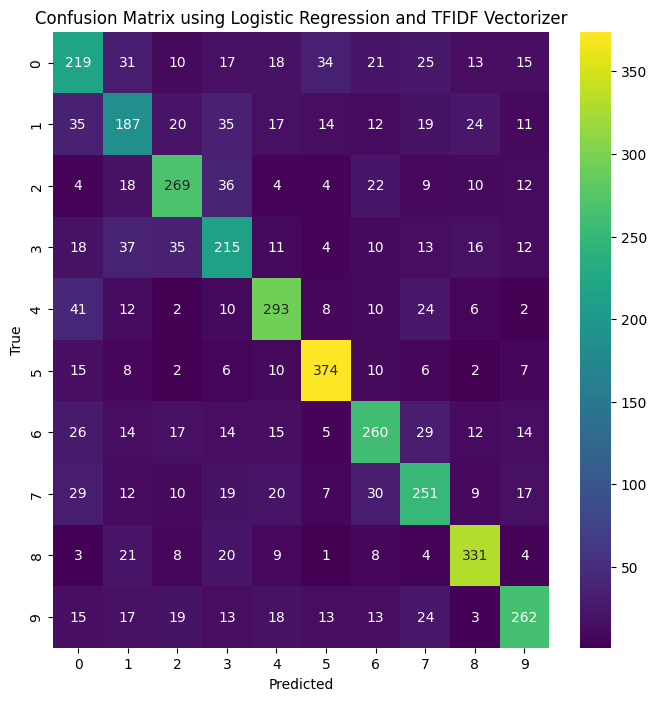

In [ ]:
# Compute confusion matrix
lr_cm = confusion_matrix(y_test, lr_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Logistic Regression and TFIDF Vectorizer')
plt.show()

#### Support Vector Machine

In [ ]:
#From mini project 3
support_vm = SVC(probability=True)

In [ ]:
svm_pipeline = Pipeline(
[('Preprocessing', tfidf_preprocessing),
 ('SVM', support_vm)
])

In [ ]:
%%time
svm_pipeline.fit(X_train, y_train)

CPU times: user 6min 55s, sys: 194 ms, total: 6min 56s
Wall time: 6min 54s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'concatenated_text')])),
                ('SVM', SVC(probability=True))])

In [ ]:
svm_y_pred = svm_pipeline.predict(X_test)
svm_y_pred

array([7, 0, 1, ..., 1, 0, 1])

In [ ]:
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"Accuracy: {svm_accuracy:.2f}")

Accuracy: 0.28


In [ ]:
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.23      0.21      0.22       403
           1       0.15      0.20      0.17       374
           2       0.34      0.32      0.33       388
           3       0.20      0.29      0.24       371
           4       0.32      0.39      0.35       408
           5       0.37      0.45      0.41       440
           6       0.33      0.17      0.23       406
           7       0.27      0.21      0.23       404
           8       0.32      0.38      0.34       409
           9       0.38      0.19      0.25       397

    accuracy                           0.28      4000
   macro avg       0.29      0.28      0.28      4000
weighted avg       0.29      0.28      0.28      4000



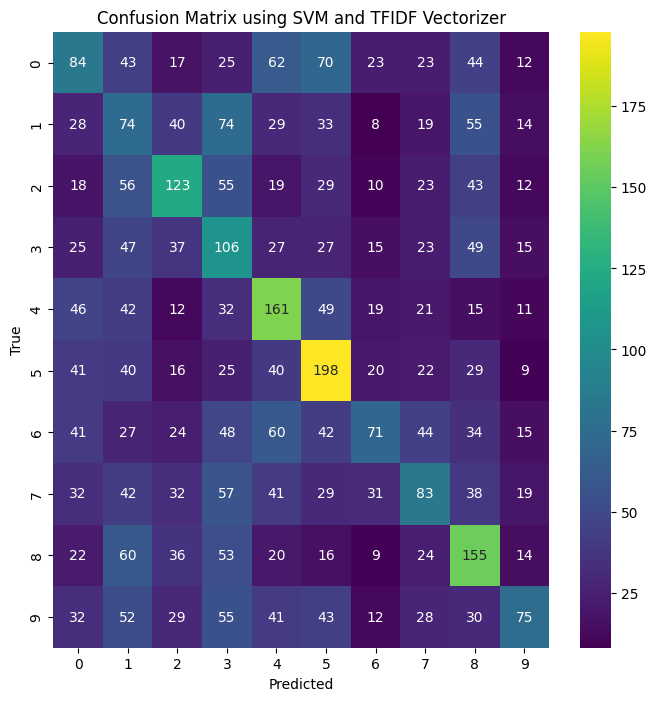

In [ ]:
# Compute confusion matrix
svm_cm = confusion_matrix(y_test, svm_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using SVM and TFIDF Vectorizer')
plt.show()

#### Gradient Boosting

In [ ]:
#From lab 7.2.2
boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [ ]:
boosting_pipeline = Pipeline(
[('Preprocessing', tfidf_preprocessing),
 ('Boost', boosting)
])

In [ ]:
%%time
boosting_pipeline.fit(X_train, y_train)

CPU times: user 39.4 s, sys: 17.6 ms, total: 39.4 s
Wall time: 39.2 s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'concatenated_text')])),
                ('Boost',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [ ]:
boosting_y_pred = boosting_pipeline.predict(X_test)
boosting_y_pred

array([1, 1, 9, ..., 1, 8, 1])

In [ ]:
boosting_accuracy = accuracy_score(y_test, boosting_y_pred)
print(f"Accuracy: {boosting_accuracy:.2f}")

Accuracy: 0.45


In [ ]:
print(classification_report(y_test, boosting_y_pred))

              precision    recall  f1-score   support

           0       0.44      0.45      0.44       403
           1       0.17      0.66      0.27       374
           2       1.00      0.01      0.01       388
           3       0.37      0.31      0.34       371
           4       0.73      0.41      0.52       408
           5       0.77      0.68      0.72       440
           6       0.58      0.52      0.55       406
           7       0.67      0.36      0.47       404
           8       0.80      0.58      0.67       409
           9       0.72      0.52      0.60       397

    accuracy                           0.45      4000
   macro avg       0.62      0.45      0.46      4000
weighted avg       0.63      0.45      0.47      4000



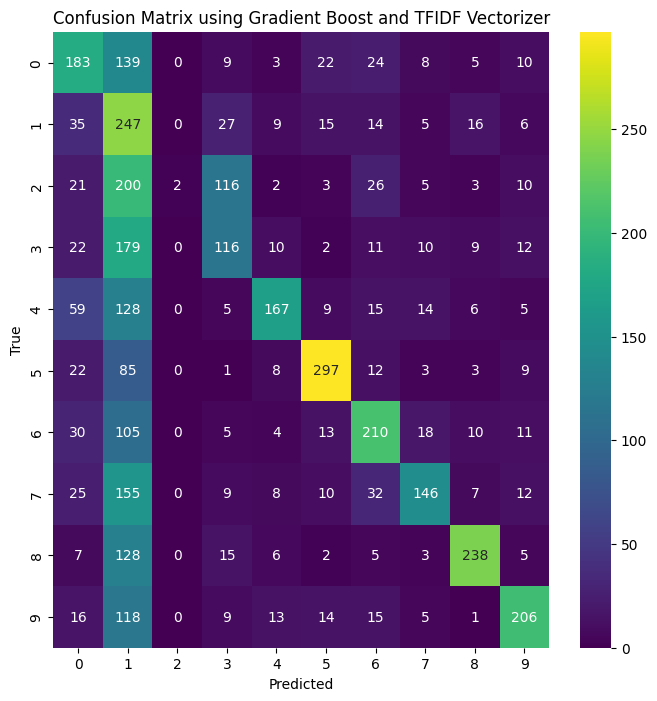

In [ ]:
# Compute confusion matrix
boosting_cm = confusion_matrix(y_test, boosting_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(boosting_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Gradient Boost and TFIDF Vectorizer')
plt.show()

#### Naive Bayes

In [ ]:
#From lab 5.3.1
nb = BernoulliNB()
nb_pipeline = Pipeline(
[('Preprocessing', tfidf_preprocessing),
 ('NaiveBayes', nb)
])

In [ ]:
%%time
nb_pipeline.fit(X_train, y_train)

CPU times: user 386 ms, sys: 2.82 ms, total: 388 ms
Wall time: 388 ms


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'concatenated_text')])),
                ('NaiveBayes', BernoulliNB())])

In [ ]:
nb_y_pred = nb_pipeline.predict(X_test)
nb_y_pred

array([6, 9, 9, ..., 2, 1, 2])

In [ ]:
nb_accuracy = accuracy_score(y_test, nb_y_pred)
print(f"Accuracy: {nb_accuracy:.2f}")

Accuracy: 0.64


In [ ]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

           0       0.64      0.41      0.50       403
           1       0.46      0.57      0.51       374
           2       0.65      0.74      0.69       388
           3       0.59      0.51      0.55       371
           4       0.67      0.77      0.72       408
           5       0.66      0.89      0.76       440
           6       0.65      0.55      0.60       406
           7       0.62      0.52      0.57       404
           8       0.78      0.82      0.80       409
           9       0.72      0.61      0.66       397

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.65      0.64      0.64      4000



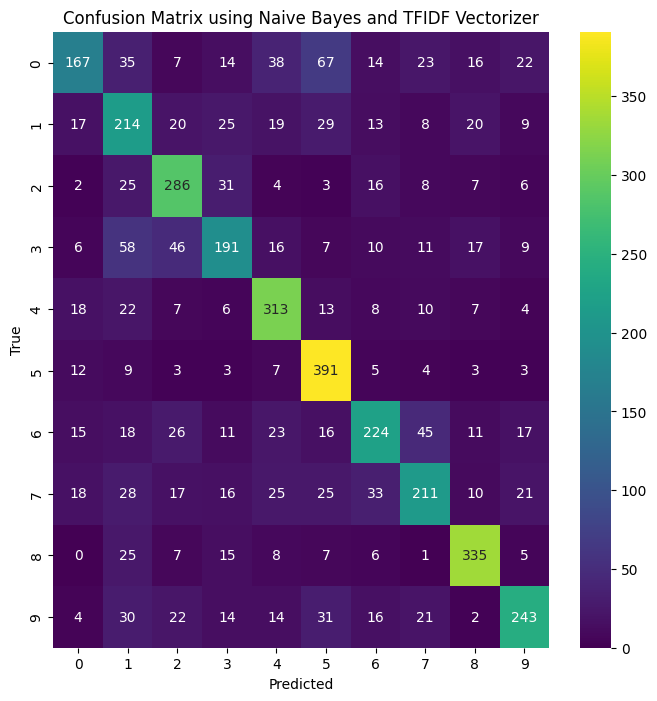

In [ ]:
# Compute confusion matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Naive Bayes and TFIDF Vectorizer')
plt.show()

### Count Vectorizer Modelling

In [ ]:
#Pipeline similar to TFIDF coding, with help of Chaitanya, stack overflow, chatgpt
count_text_preprocessing = Pipeline(
[
     ('CountText', CountVectorizer())
]
)

In [ ]:
count_preprocessing = make_column_transformer(
     (numeric_preprocessing, numeric_columns),
    (count_text_preprocessing, 'concatenated_text')
)

#### Logistic Regression

In [ ]:
lr_pipeline2 = Pipeline(
[('Preprocessing', count_preprocessing),
 ('LogisticRegression', lr)
])

In [ ]:
%%time
lr_pipeline2.fit(X_train, y_train)

CPU times: user 27.9 s, sys: 1min 46s, total: 2min 14s
Wall time: 12.4 s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('CountText',
                                                                   CountVectorizer())]),
                                                  'concatenated_text')])),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
lr_y_pred2 = lr_pipeline2.predict(X_test)
lr_y_pred2

array([6, 9, 9, ..., 2, 1, 2])

In [ ]:
lr_accuracy2 = accuracy_score(y_test, lr_y_pred2)
print(f"Accuracy: {lr_accuracy2:.2f}")

Accuracy: 0.64


In [ ]:
print(classification_report(y_test, lr_y_pred2))

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       403
           1       0.46      0.53      0.49       374
           2       0.64      0.65      0.65       388
           3       0.53      0.54      0.54       371
           4       0.72      0.68      0.70       408
           5       0.83      0.82      0.82       440
           6       0.62      0.59      0.60       406
           7       0.58      0.62      0.60       404
           8       0.77      0.80      0.79       409
           9       0.72      0.66      0.69       397

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.65      0.64      0.64      4000



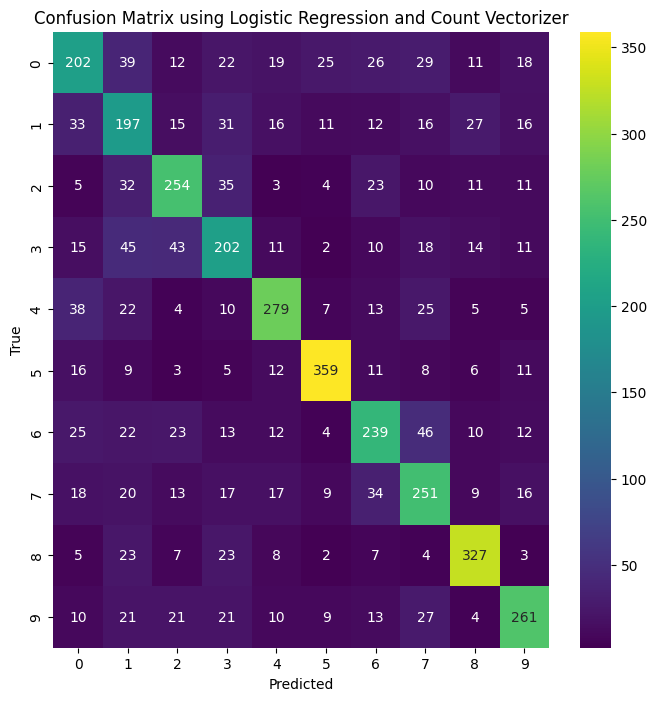

In [ ]:
# Compute confusion matrix
lr_cm2 = confusion_matrix(y_test, lr_y_pred2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(lr_cm2, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Logistic Regression and Count Vectorizer')
plt.show()

#### Support Vector Machine

In [ ]:
svm_pipeline2 = Pipeline(
[('Preprocessing', count_preprocessing),
 ('SVM', support_vm)
])

In [ ]:
%%time
svm_pipeline2.fit(X_train, y_train)

CPU times: user 7min 1s, sys: 183 ms, total: 7min 1s
Wall time: 6min 59s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('CountText',
                                                                   CountVectorizer())]),
                                                  'concatenated_text')])),
                ('SVM', SVC(probability=True))])

In [ ]:
svm_y_pred2 = svm_pipeline2.predict(X_test)
svm_y_pred2

array([6, 1, 9, ..., 1, 0, 1])

In [ ]:
svm_accuracy2 = accuracy_score(y_test, svm_y_pred2)
print(f"Accuracy: {svm_accuracy2:.2f}")

Accuracy: 0.57


In [ ]:
print(classification_report(y_test, svm_y_pred2))

              precision    recall  f1-score   support

           0       0.40      0.50      0.45       403
           1       0.33      0.52      0.40       374
           2       0.69      0.62      0.65       388
           3       0.46      0.47      0.47       371
           4       0.73      0.67      0.70       408
           5       0.69      0.72      0.70       440
           6       0.58      0.54      0.56       406
           7       0.52      0.50      0.51       404
           8       0.77      0.64      0.70       409
           9       0.75      0.48      0.59       397

    accuracy                           0.57      4000
   macro avg       0.59      0.57      0.57      4000
weighted avg       0.60      0.57      0.58      4000



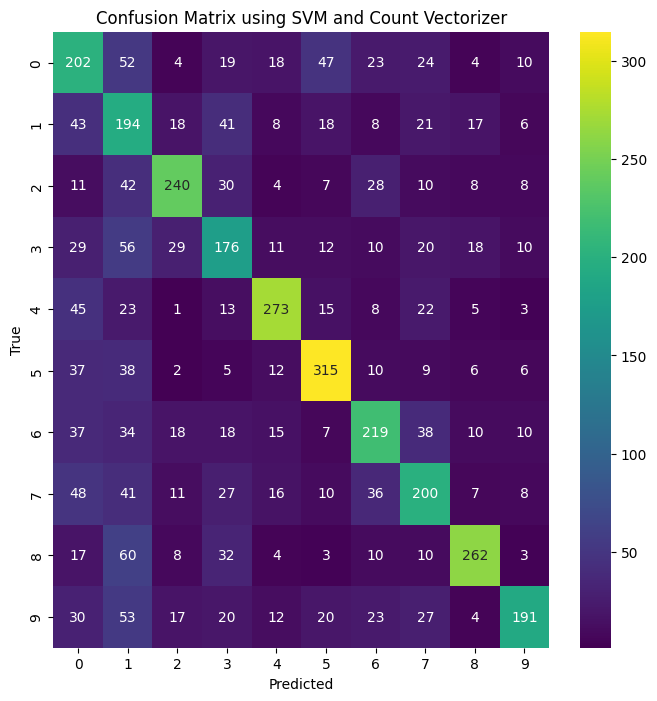

In [ ]:
# Compute confusion matrix
svm_cm2 = confusion_matrix(y_test, svm_y_pred2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(svm_cm2, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using SVM and Count Vectorizer')
plt.show()

#### Gradient Boosting

In [ ]:
boosting_pipeline2 = Pipeline(
[('Preprocessing', count_preprocessing),
 ('Boost', boosting)
])

In [ ]:
%%time
boosting_pipeline2.fit(X_train, y_train)

CPU times: user 23.8 s, sys: 8.62 ms, total: 23.8 s
Wall time: 23.8 s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('CountText',
                                                                   CountVectorizer())]),
                                                  'concatenated_text')])),
                ('Boost',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [ ]:
boosting_y_pred2 = boosting_pipeline2.predict(X_test)
boosting_y_pred2

array([6, 1, 1, ..., 1, 8, 1])

In [ ]:
boosting_accuracy2 = accuracy_score(y_test, boosting_y_pred2)
print(f"Accuracy: {boosting_accuracy2:.2f}")

Accuracy: 0.47


In [ ]:
print(classification_report(y_test, boosting_y_pred2))

              precision    recall  f1-score   support

           0       0.43      0.44      0.44       403
           1       0.17      0.65      0.27       374
           2       0.64      0.26      0.37       388
           3       0.65      0.29      0.40       371
           4       0.72      0.42      0.53       408
           5       0.71      0.62      0.66       440
           6       0.59      0.50      0.54       406
           7       0.62      0.44      0.51       404
           8       0.76      0.66      0.70       409
           9       0.74      0.38      0.50       397

    accuracy                           0.47      4000
   macro avg       0.60      0.47      0.49      4000
weighted avg       0.61      0.47      0.50      4000



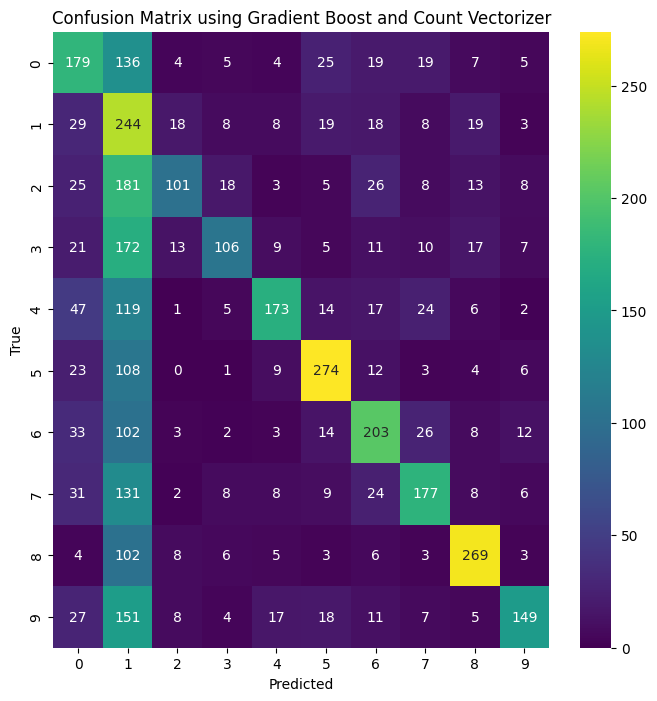

In [ ]:
# Compute confusion matrix
boosting_cm2 = confusion_matrix(y_test, boosting_y_pred2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(boosting_cm2, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Gradient Boost and Count Vectorizer')
plt.show()

#### Naive Bayes

In [ ]:
nb_pipeline2 = Pipeline(
[('Preprocessing', count_preprocessing),
 ('bayes', nb)
])

In [ ]:
%%time
nb_pipeline2.fit(X_train, y_train)

CPU times: user 501 ms, sys: 0 ns, total: 501 ms
Wall time: 500 ms


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['char_count', 'word_count',
                                                   'word_density',
                                                   'title_count',
                                                   'uppercase_count',
                                                   'adj_count', 'adv_count',
                                                   'noun_count', 'num_count',
                                                   'pron_count', 'propn_count',
                                                   'verb_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('CountText',
                                                                   CountVectorizer())]),
                                                  'concatenated_text')])),
                ('bayes', BernoulliNB())])

In [ ]:
nb_y_pred2 = nb_pipeline2.predict(X_test)
nb_y_pred2

array([6, 9, 9, ..., 2, 1, 2])

In [ ]:
nb_accuracy2 = accuracy_score(y_test, nb_y_pred2)
print(f"Accuracy: {boosting_accuracy2:.2f}")

Accuracy: 0.47


In [ ]:
print(classification_report(y_test, nb_y_pred2))

              precision    recall  f1-score   support

           0       0.64      0.41      0.50       403
           1       0.46      0.57      0.51       374
           2       0.65      0.74      0.69       388
           3       0.59      0.51      0.55       371
           4       0.67      0.77      0.72       408
           5       0.66      0.89      0.76       440
           6       0.65      0.55      0.60       406
           7       0.62      0.52      0.57       404
           8       0.78      0.82      0.80       409
           9       0.72      0.61      0.66       397

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.65      0.64      0.64      4000



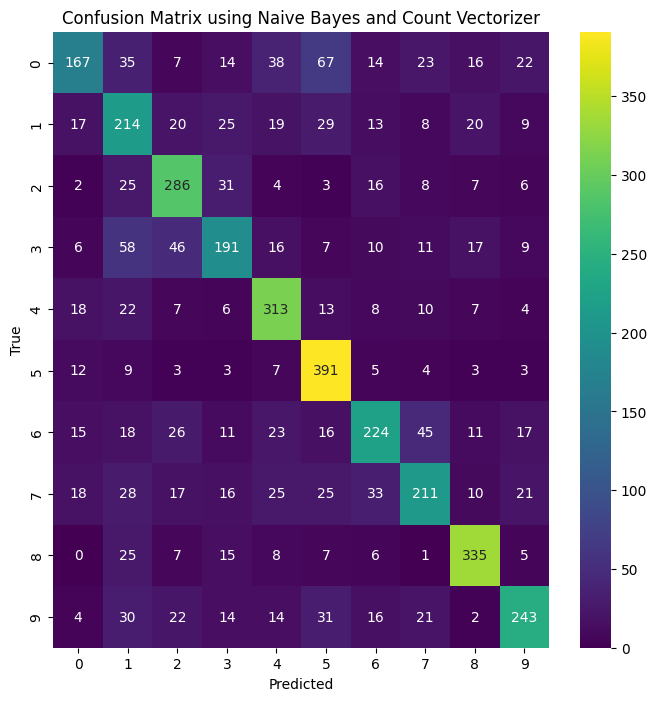

In [ ]:
# Compute confusion matrix
nb_cm2 = confusion_matrix(y_test, nb_y_pred2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(nb_cm2, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Naive Bayes and Count Vectorizer')
plt.show()

### Hyperparameter Tuning

We will now tune the models to see if we can improve the results of our modelling. We used RandomizedSearchCV instead of GridSearchCV as according to some discussions on Stack Overflow, it is faster than GridSearchCV.

#### Tuning for TFIDF Vectorizer Models

#### Logistic Regression

In [ ]:
#ChatGPT help
lr_param_grid = {
    'LogisticRegression__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'LogisticRegression__solver': ['liblinear', 'saga']
}

In [ ]:
lr_rand_search = RandomizedSearchCV(lr_pipeline, lr_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=9)

In [ ]:
%%time
lr_rand_search.fit(X_train, y_train)

CPU times: user 3min 59s, sys: 10min 20s, total: 14min 19s
Wall time: 2min 14s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_count']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('LogisticRegression',
                                              LogisticRegression())]),
                   param_distributions={'LogisticRegression__C': [0.001, 0.01,
                                                                  0.1, 1.0,
                                                                  10.0],
                                        'LogisticRegression__solver': ['liblinear',
                                                                       'saga']},
                   random_state=9, scoring='accuracy')

In [ ]:
lr_rand_search.best_params_

{'LogisticRegression__solver': 'saga', 'LogisticRegression__C': 10.0}

In [ ]:
post_lr_pred = lr_rand_search.predict(X_test)
post_lr_pred

array([6, 1, 9, ..., 2, 1, 2])

In [ ]:
post_lr_accuracy = accuracy_score(y_test, post_lr_pred)
print(f"Accuracy: {post_lr_accuracy:.2f}")

Accuracy: 0.67


In [ ]:
print(classification_report(y_test, post_lr_pred))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       403
           1       0.52      0.52      0.52       374
           2       0.69      0.70      0.69       388
           3       0.56      0.58      0.57       371
           4       0.71      0.73      0.72       408
           5       0.82      0.85      0.83       440
           6       0.65      0.64      0.64       406
           7       0.63      0.62      0.63       404
           8       0.79      0.80      0.80       409
           9       0.73      0.68      0.70       397

    accuracy                           0.67      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.67      0.67      0.67      4000



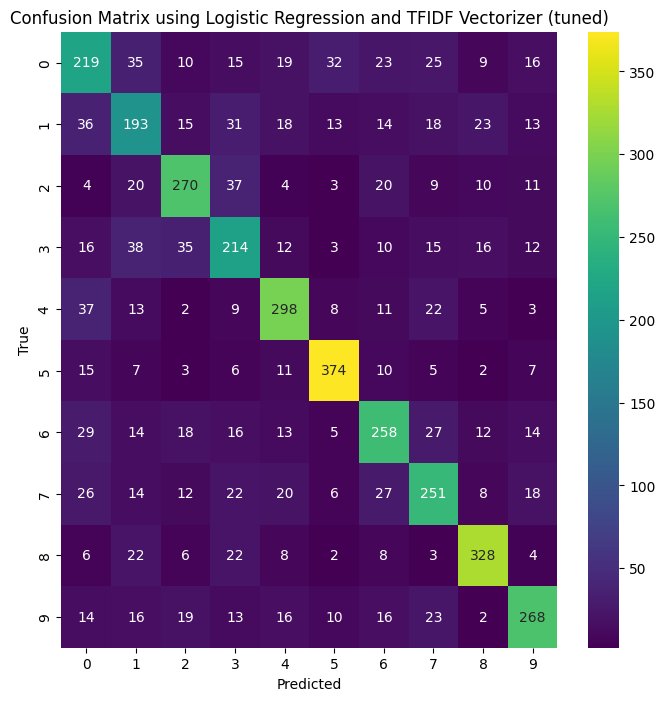

In [ ]:
# Compute confusion matrix
post_lr_cm = confusion_matrix(y_test, post_lr_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_lr_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Logistic Regression and TFIDF Vectorizer (tuned)')
plt.show()

#### Support Vector Machine

In [ ]:
param_grid_svm = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'rbf', 'poly']}

In [ ]:
randomized_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_grid_svm,
    cv=5, # Number of cross-validation folds
    n_iter=10, # Number of parameter settings that are sampled
    n_jobs=-1, # Number of jobs to run in parallel (-1 means using all processors)
    random_state=42 # Random state for reproducibility
)

In [ ]:
%%time
randomized_search_svm.fit(X_train, y_train)

CPU times: user 10min 30s, sys: 5.28 s, total: 10min 35s
Wall time: 44min 26s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_count']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('SVM', SVC(probability=True))]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': [0.1, 1, 10, 100],
                                        'SVM__kernel': ['linear', 'rbf',
                                                        'poly']},
                   random_state=42)

In [ ]:
randomized_search_svm.best_params_

{'SVM__kernel': 'linear', 'SVM__C': 100}

In [ ]:
post_svm_pred = randomized_search_svm.predict(X_test)
post_svm_pred

array([6, 1, 9, ..., 2, 1, 2])

In [ ]:
post_svm_accuracy = accuracy_score(y_test, post_svm_pred)
print(f"Accuracy: {post_svm_accuracy:.2f}")

Accuracy: 0.63


In [ ]:
print(classification_report(y_test, post_svm_pred))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       403
           1       0.43      0.49      0.46       374
           2       0.62      0.65      0.64       388
           3       0.52      0.49      0.50       371
           4       0.73      0.69      0.71       408
           5       0.85      0.82      0.83       440
           6       0.59      0.58      0.59       406
           7       0.56      0.55      0.56       404
           8       0.83      0.78      0.81       409
           9       0.71      0.65      0.68       397

    accuracy                           0.63      4000
   macro avg       0.63      0.63      0.63      4000
weighted avg       0.64      0.63      0.63      4000



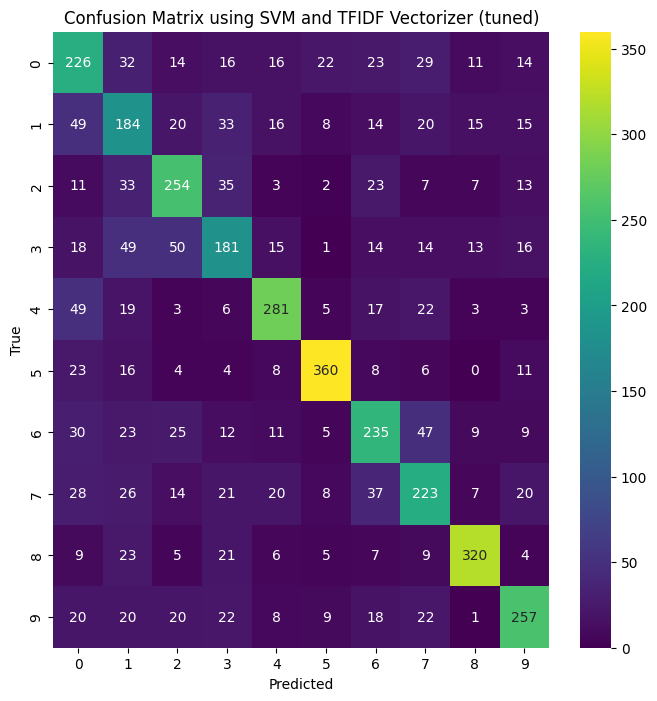

In [ ]:
post_svm_cm = confusion_matrix(y_test, post_svm_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_svm_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using SVM and TFIDF Vectorizer (tuned)')
plt.show()

#### Gradient Boosting

In [ ]:
param_grid_gb = {
    'Boost__n_estimators': [100, 200, 300],
    'Boost__learning_rate': [0.1, 0.05, 0.01],
    'Boost__max_depth': [3, 4, 5]}

In [ ]:
random_search_gb = RandomizedSearchCV(estimator=boosting_pipeline,
                                      param_distributions=param_grid_gb,
                                      n_iter=10,  # Number of parameter settings that are sampled
                                      cv=5,       # Number of folds for cross-validation
                                      n_jobs=-1) # Use all available CPU cores

In [ ]:
%%time
random_search_gb.fit(X_train, y_train)

CPU times: user 9min 3s, sys: 4.53 s, total: 9min 8s
Wall time: 39min 28s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_count']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('Boost',
                                              GradientBoostingClassifier(learning_rate=1.0,
                                                                         max_depth=1,
                                                                         random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'Boost__learning_rate': [0.1, 0.05,
                                                                 0.01],
                                        'Boost__max_depth': [3, 4, 5],
                                        'Boost__n_estimators': [100, 200, 300]})

In [ ]:
random_search_gb.best_params_

{'Boost__n_estimators': 300,
 'Boost__max_depth': 5,
 'Boost__learning_rate': 0.1}

In [ ]:
post_gb_pred = random_search_gb.predict(X_test)
post_gb_pred

array([1, 0, 9, ..., 1, 1, 2])

In [ ]:
post_gb_accuracy = accuracy_score(y_test, post_gb_pred)
print(f"Accuracy: {post_gb_accuracy:.2f}")

Accuracy: 0.62


In [ ]:
print(classification_report(y_test, post_gb_pred))

              precision    recall  f1-score   support

           0       0.45      0.53      0.49       403
           1       0.37      0.50      0.43       374
           2       0.66      0.69      0.67       388
           3       0.53      0.48      0.50       371
           4       0.70      0.69      0.69       408
           5       0.83      0.79      0.81       440
           6       0.64      0.56      0.60       406
           7       0.61      0.56      0.59       404
           8       0.82      0.74      0.78       409
           9       0.72      0.67      0.69       397

    accuracy                           0.62      4000
   macro avg       0.63      0.62      0.62      4000
weighted avg       0.64      0.62      0.63      4000



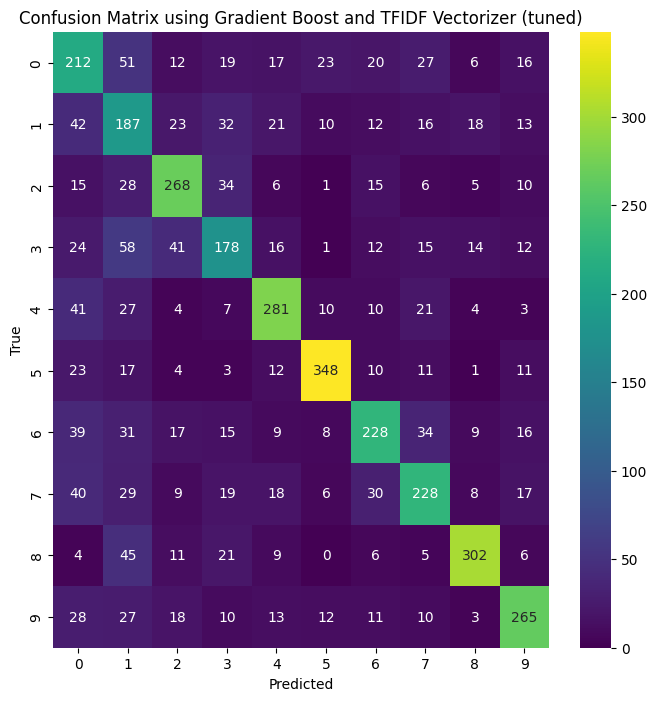

In [ ]:
post_gb_cm = confusion_matrix(y_test, post_gb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_gb_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Gradient Boost and TFIDF Vectorizer (tuned)')
plt.show()

#### Naive Bayes

In [ ]:
nb_param_grid = {
    'NaiveBayes__alpha': uniform(0.0, 1.0),  # Continuous uniform distribution for alpha
    'NaiveBayes__binarize': uniform(0.0, 1.0),  # Continuous uniform distribution for binarize
    'NaiveBayes__fit_prior': [True, False]  # Discrete uniform distribution for fit_prior
}

In [ ]:
nb_rand_search = RandomizedSearchCV(nb_pipeline, nb_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

In [ ]:
%%time
nb_rand_search.fit(X_train, y_train)

CPU times: user 20 s, sys: 48.3 ms, total: 20.1 s
Wall time: 20 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_cou...
                                                                               'concatenated_text')])),
                                             ('NaiveBayes', BernoulliNB())]),
                   param_distributions={'NaiveBayes__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78f81d92a4d0>,
                                        'NaiveBayes__binarize': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78f79e041630>,
                                        'NaiveBayes__fit_prior': [True, False]},
                   random_state=42, scoring='accuracy')

In [ ]:
nb_rand_search.best_params_

{'NaiveBayes__alpha': 0.6118528947223795,
 'NaiveBayes__binarize': 0.13949386065204183,
 'NaiveBayes__fit_prior': False}

In [ ]:
post_nb_pred = nb_rand_search.predict(X_test)
post_nb_pred

array([6, 9, 9, ..., 2, 1, 2])

In [ ]:
post_nb_accuracy = accuracy_score(y_test, post_nb_pred)
print(f"Accuracy: {post_nb_accuracy:.2f}")

Accuracy: 0.64


In [ ]:
print(classification_report(y_test, post_nb_pred))

              precision    recall  f1-score   support

           0       0.64      0.42      0.51       403
           1       0.46      0.53      0.50       374
           2       0.65      0.71      0.67       388
           3       0.58      0.52      0.55       371
           4       0.65      0.76      0.70       408
           5       0.68      0.88      0.77       440
           6       0.64      0.58      0.61       406
           7       0.62      0.54      0.57       404
           8       0.80      0.82      0.81       409
           9       0.68      0.63      0.65       397

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.63      4000
weighted avg       0.64      0.64      0.64      4000



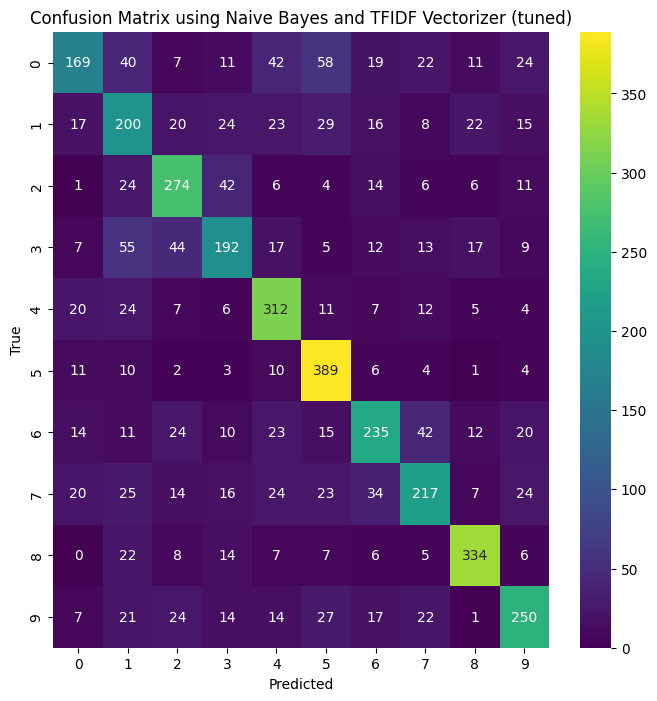

In [ ]:
post_nb_cm = confusion_matrix(y_test, post_nb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_nb_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Naive Bayes and TFIDF Vectorizer (tuned)')
plt.show()

#### Tuning for Count Vectorizer Models

#### Logistic Regression

In [ ]:
lr_rand_search2 = RandomizedSearchCV(lr_pipeline2, lr_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=9)

In [ ]:
%%time
# Perform grid search cross-validation
lr_rand_search2.fit(X_train, y_train)

CPU times: user 4min 21s, sys: 11min 29s, total: 15min 51s
Wall time: 2min 23s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_count']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('CountText',
                                                                                                CountVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('LogisticRegression',
                                              LogisticRegression())]),
                   param_distributions={'LogisticRegression__C': [0.001, 0.01,
                                                                  0.1, 1.0,
                                                                  10.0],
                                        'LogisticRegression__solver': ['liblinear',
                                                                       'saga']},
                   random_state=9, scoring='accuracy')

In [ ]:
lr_rand_search2.best_params_

{'LogisticRegression__solver': 'liblinear', 'LogisticRegression__C': 1.0}

In [ ]:
post_lr2_pred = lr_rand_search2.predict(X_test)
post_lr2_pred

array([6, 1, 9, ..., 2, 7, 2])

In [ ]:
post_lr2_accuracy = accuracy_score(y_test, post_lr2_pred)
print(f"Accuracy: {post_lr2_accuracy:.2f}")

Accuracy: 0.65


In [ ]:
print(classification_report(y_test, post_lr2_pred))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       403
           1       0.48      0.52      0.50       374
           2       0.65      0.66      0.66       388
           3       0.55      0.54      0.54       371
           4       0.73      0.70      0.71       408
           5       0.81      0.85      0.83       440
           6       0.62      0.61      0.61       406
           7       0.59      0.62      0.60       404
           8       0.77      0.81      0.79       409
           9       0.71      0.67      0.69       397

    accuracy                           0.65      4000
   macro avg       0.65      0.65      0.65      4000
weighted avg       0.65      0.65      0.65      4000



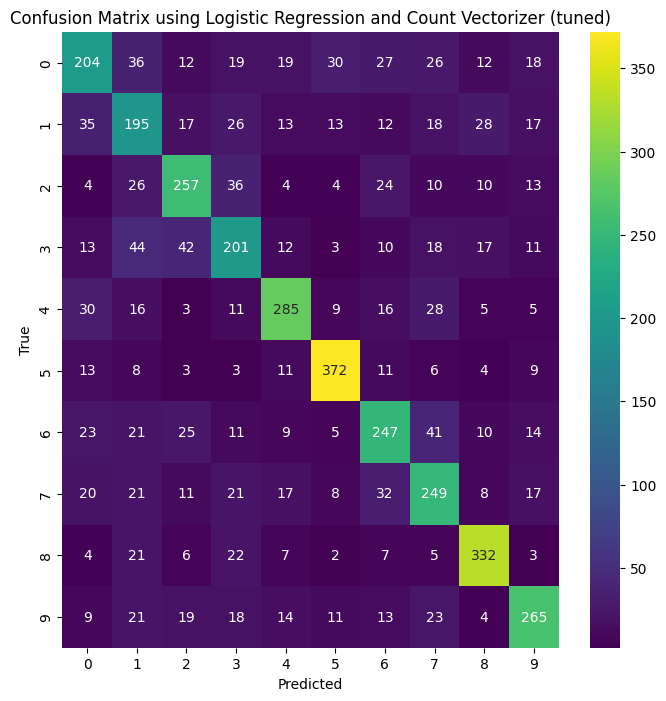

In [ ]:
post_lr2_cm = confusion_matrix(y_test, post_lr2_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_lr2_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Logistic Regression and Count Vectorizer (tuned)')
plt.show()

#### Support Vector Machines

In [ ]:
rand_search_svm = RandomizedSearchCV(
    svm_pipeline2,
    param_distributions= param_grid_svm,
    cv=5, # Number of cross-validation folds
    n_iter=10, # Number of parameter settings that are sampled
    n_jobs=-1, # Number of jobs to run in parallel (-1 means using all processors)
    random_state=9 #Random state for reproducibility
)

In [ ]:
%%time
rand_search_svm.fit(X_train, y_train)

CPU times: user 4min 53s, sys: 4.5 s, total: 4min 58s
Wall time: 34min 43s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_count']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('CountText',
                                                                                                CountVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('SVM', SVC(probability=True))]),
                   n_jobs=-1,
                   param_distributions={'SVM__C': [0.1, 1, 10, 100],
                                        'SVM__kernel': ['linear', 'rbf',
                                                        'poly']},
                   random_state=9)

In [ ]:
rand_search_svm.best_params_

{'SVM__kernel': 'linear', 'SVM__C': 0.1}

In [ ]:
post_svm2_pred = rand_search_svm.predict(X_test)
post_svm2_pred

array([6, 1, 9, ..., 2, 1, 1])

In [ ]:
post_svm2_accuracy = accuracy_score(y_test, post_svm2_pred)
print(f"Accuracy: {post_svm2_accuracy:.2f}")

Accuracy: 0.62


In [ ]:
print(classification_report(y_test, post_svm2_pred))

              precision    recall  f1-score   support

           0       0.51      0.52      0.52       403
           1       0.37      0.56      0.45       374
           2       0.65      0.66      0.66       388
           3       0.53      0.50      0.51       371
           4       0.74      0.68      0.71       408
           5       0.82      0.81      0.82       440
           6       0.63      0.53      0.58       406
           7       0.56      0.57      0.57       404
           8       0.80      0.75      0.77       409
           9       0.75      0.61      0.67       397

    accuracy                           0.62      4000
   macro avg       0.64      0.62      0.63      4000
weighted avg       0.64      0.62      0.63      4000



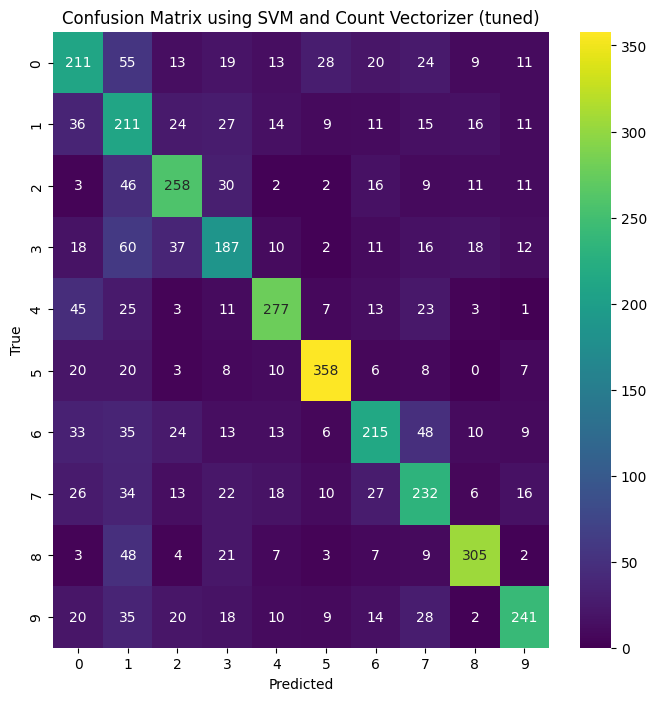

In [ ]:
post_svm2_cm = confusion_matrix(y_test, post_svm2_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_svm2_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using SVM and Count Vectorizer (tuned)')
plt.show()

#### Gradient Boosting

In [ ]:
rand_search_gb = RandomizedSearchCV(estimator=boosting_pipeline2,
                                      param_distributions=param_grid_gb,
                                      n_iter=10,  # Number of parameter settings that are sampled
                                      cv=5,       # Number of folds for cross-validation
                                      n_jobs=-1) # Use all available CPU cores

In [ ]:
%%time
rand_search_gb.fit(X_train, y_train)

CPU times: user 4min 14s, sys: 3.64 s, total: 4min 17s
Wall time: 24min 48s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_count']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('CountText',
                                                                                                CountVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('Boost',
                                              GradientBoostingClassifier(learning_rate=1.0,
                                                                         max_depth=1,
                                                                         random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'Boost__learning_rate': [0.1, 0.05,
                                                                 0.01],
                                        'Boost__max_depth': [3, 4, 5],
                                        'Boost__n_estimators': [100, 200, 300]})

In [ ]:
rand_search_gb.best_params_

{'Boost__n_estimators': 300,
 'Boost__max_depth': 4,
 'Boost__learning_rate': 0.1}

In [ ]:
post_gb2_pred = rand_search_gb.predict(X_test)
post_gb2_pred

array([6, 0, 9, ..., 9, 1, 1])

In [ ]:
post_gb2_accuracy = accuracy_score(y_test, post_gb2_pred)
print(f"Accuracy: {post_gb2_accuracy:.2f}")

Accuracy: 0.62


In [ ]:
print(classification_report(y_test, post_gb2_pred))

              precision    recall  f1-score   support

           0       0.45      0.56      0.50       403
           1       0.37      0.50      0.43       374
           2       0.69      0.65      0.67       388
           3       0.52      0.47      0.49       371
           4       0.69      0.68      0.69       408
           5       0.81      0.78      0.79       440
           6       0.66      0.58      0.62       406
           7       0.64      0.58      0.61       404
           8       0.80      0.73      0.76       409
           9       0.72      0.67      0.69       397

    accuracy                           0.62      4000
   macro avg       0.64      0.62      0.63      4000
weighted avg       0.64      0.62      0.63      4000



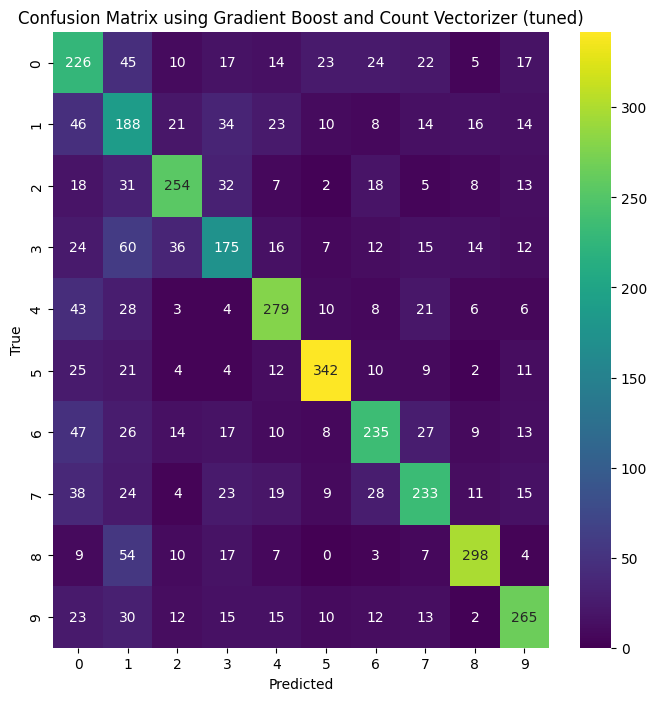

In [ ]:
post_gb2_cm = confusion_matrix(y_test, post_gb2_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_gb2_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Gradient Boost and Count Vectorizer (tuned)')
plt.show()

#### Naive Bayes

In [ ]:
nb_param_grid2 = {
    'bayes__alpha': uniform(0.0, 1.0),  # Continuous uniform distribution for alpha
    'bayes__binarize': uniform(0.0, 1.0),  # Continuous uniform distribution for binarize
    'bayes__fit_prior': [True, False]  # Discrete uniform distribution for fit_prior
}

In [ ]:
nb_random_search = RandomizedSearchCV(nb_pipeline2, nb_param_grid2, n_iter=10, cv=5, scoring='accuracy', random_state=9)

In [ ]:
%%time
nb_random_search.fit(X_train, y_train)

CPU times: user 19.3 s, sys: 36.3 ms, total: 19.4 s
Wall time: 19.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer()),
                                                                                               ('Scaling',
                                                                                                StandardScaler())]),
                                                                               ['char_count',
                                                                                'word_count',
                                                                                'word_density',
                                                                                'title_count',
                                                                                'uppercase_count',
                                                                                'adj_count',
                                                                                'adv_count',
                                                                                'noun_count',
                                                                                'num_count',
                                                                                'pron_count',
                                                                                'propn_count',
                                                                                'verb_cou...
                                                                                                CountVectorizer())]),
                                                                               'concatenated_text')])),
                                             ('bayes', BernoulliNB())]),
                   param_distributions={'bayes__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78f7967043a0>,
                                        'bayes__binarize': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78f797bb22c0>,
                                        'bayes__fit_prior': [True, False]},
                   random_state=9, scoring='accuracy')

In [ ]:
nb_random_search.best_params_

{'bayes__alpha': 0.5727598155694092,
 'bayes__binarize': 0.8980071182251496,
 'bayes__fit_prior': True}

In [ ]:
post_nb2_pred = nb_random_search.predict(X_test)
post_nb2_pred

array([6, 1, 9, ..., 2, 1, 2])

In [ ]:
post_nb2_accuracy = accuracy_score(y_test, post_nb2_pred)
print(f"Accuracy: {post_nb2_accuracy:.2f}")

Accuracy: 0.65


In [ ]:
print(classification_report(y_test, post_nb2_pred))

              precision    recall  f1-score   support

           0       0.60      0.40      0.48       403
           1       0.48      0.55      0.51       374
           2       0.66      0.73      0.69       388
           3       0.60      0.51      0.55       371
           4       0.66      0.76      0.71       408
           5       0.69      0.89      0.78       440
           6       0.63      0.57      0.60       406
           7       0.61      0.53      0.57       404
           8       0.79      0.84      0.82       409
           9       0.70      0.63      0.66       397

    accuracy                           0.65      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.65      0.64      4000



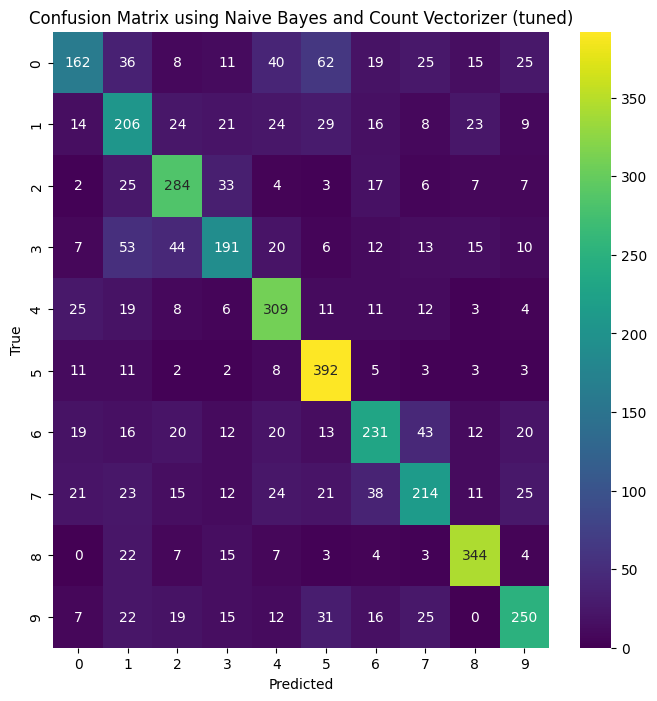

In [ ]:
post_nb2_cm = confusion_matrix(y_test, post_nb2_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(post_nb2_cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Naive Bayes and Count Vectorizer (tuned)')
plt.show()

### Compare Accuracy Results

#### Accuracy prior to RandomizedSearchCV.

In [ ]:
pre_cv_results = pd.DataFrame(columns = ['Count Vectorizer', 'TF-IDF Vectorizer'])

In [166]:
pre_cv_results.loc['Logistic Regression'] = {
    'Count Vectorizer': lr_accuracy2,
    'TF-IDF Vectorizer': lr_accuracy}

In [167]:
pre_cv_results.loc['SVM'] = {
    'Count Vectorizer': svm_accuracy2,
    'TF-IDF Vectorizer': svm_accuracy}

In [168]:
pre_cv_results.loc['Naive Bayes'] = {
    'Count Vectorizer': nb_accuracy2,
    'TF-IDF Vectorizer': nb_accuracy}

In [169]:
pre_cv_results.loc['Boosting'] = {
    'Count Vectorizer': boosting_accuracy2,
    'TF-IDF Vectorizer': boosting_accuracy}

In [170]:
pre_cv_results

,Count Vectorizer,TF-IDF Vectorizer
Logistic Regression,0.64275,0.66525
SVM,0.56800,0.28250
Naive Bayes,0.64375,0.64375
Boosting,0.46875,0.45300


- Some models did not perform as well as others.
- The highest accuracy results was Logistic Regression with TFIDF Vectorizer model.
- Performing RandomizedSearchCV will hopefully improve model accuracies.

#### Accuracy after RandomizedSearchCV

In [ ]:
post_cv_results = pd.DataFrame(columns = ['Count Vectorizer', 'TF-IDF Vectorizer'])

In [156]:
post_cv_results.loc['Logistic Regression'] = {
    'Count Vectorizer': post_lr2_accuracy,
    'TF-IDF Vectorizer': post_lr_accuracy}

In [157]:
post_cv_results.loc['SVM'] = {
    'Count Vectorizer': post_svm2_accuracy,
    'TF-IDF Vectorizer': post_svm_accuracy}

In [158]:
post_cv_results.loc['Naive Bayes'] = {
    'Count Vectorizer': post_nb2_accuracy,
    'TF-IDF Vectorizer': post_nb_accuracy}

In [159]:
post_cv_results.loc['Boosting'] = {
    'Count Vectorizer': post_gb2_accuracy,
    'TF-IDF Vectorizer': post_gb_accuracy}

In [160]:
post_cv_results

,Count Vectorizer,TF-IDF Vectorizer
Logistic Regression,0.65175,0.66825
SVM,0.62375,0.63025
Naive Bayes,0.64575,0.64300
Boosting,0.62375,0.62425


- Some models significantly improved (SVM went up from 28% to 63%).
- The model with highest accuracy is still Logistic Regression with TFIDF Vectorizer at 66.8% accuracy.

### Testing the best model using unseen data (made-up headlines)

In [ ]:
#ChatGPT help
def preprocess_sentence(sentence):
    tokenized_sentence = word_tokenize(sentence)
    processed_sentence = [token.lower() for token in tokenized_sentence]
    stop_words = set(stopwords.words('english'))
    processed_sentence = [token for token in processed_sentence if token not in stop_words]
    return processed_sentence

In [ ]:
def pos_tagging(sentence):
    pos_tags = pos_tag(sentence)
    return pos_tags

In [ ]:
def extract_features(sentence, pos_tags):
    feature_vector = []
    for word, pos_tag in pos_tags:
        feature_vector.append((word, pos_tag))
    return feature_vector

In [ ]:
def predict_category(model, headline, description):
    # Preprocess the sentence
    processed_headline = preprocess_sentence(headline)
    processed_description = preprocess_sentence(description)

    # Perform POS tagging
    pos_tags_headline = pos_tagging(processed_headline)
    pos_tags_description = pos_tagging(processed_description)

    # Extract features
    feature_vector_headline = extract_features(processed_headline, pos_tags_headline)
    feature_vector_description = extract_features(processed_description, pos_tags_description)

    # Combine tokenized headline and description
    concatenated_text = ' '.join(processed_headline + processed_description)

    # Create DataFrame with features
    new_data = pd.DataFrame({'tokenized_headline': [' '.join(processed_headline)],
                             'tokenized_description': [' '.join(processed_description)],
                             'char_count': [len(concatenated_text)],
                             'word_count': [len(concatenated_text.split())],
                             'word_density': [len(concatenated_text) / (len(concatenated_text.split()) + 1)],
                             'title_count': [sum(1 for word in concatenated_text.split() if word.istitle())],
                             'uppercase_count': [sum(1 for char in concatenated_text if char.isupper())],
                             'adj_count': [sum(1 for word, pos in pos_tags_headline if pos.startswith('JJ'))],
                             'adv_count': [sum(1 for word, pos in pos_tags_headline if pos.startswith('RB'))],
                             'noun_count': [sum(1 for word, pos in pos_tags_headline if pos.startswith('NN'))],
                             'num_count': [sum(1 for word, pos in pos_tags_headline if pos.startswith('CD'))],
                             'pron_count': [sum(1 for word, pos in pos_tags_headline if pos.startswith('PRP'))],
                             'propn_count': [sum(1 for word, pos in pos_tags_headline if pos == 'NNP')],
                             'verb_count': [sum(1 for word, pos in pos_tags_headline if pos.startswith('VB'))],
                             'concatenated_text': [concatenated_text]})

    # Predict the category
    predicted_category = model.predict(new_data)
    category_map = {0: 'lifestyle', 1: 'entertainment', 2: 'politics', 3: 'global', 4: 'family', 5: 'food', 6: 'business', 7: 'education', 8:  'sports', 9: 'environment'}
    # Map the numerical category label to its corresponding category in words
    category_in_words = category_map[predicted_category[0]]

    return category_in_words

In [ ]:
#chatgpt generated
new_headline = "A new study suggests drinking coffee may reduce the risk of heart disease"
new_description = "Researchers have found evidence that drinking coffee may have cardiovascular benefits."
predicted_category = predict_category(lr_rand_search2, new_headline, new_description)
print(f"Headline: {new_headline}")
print(f"Description: {new_description}")
print("Predicted Category:", predicted_category)

Headline: A new study suggests drinking coffee may reduce the risk of heart disease
Description: Researchers have found evidence that drinking coffee may have cardiovascular benefits.
Predicted Category: lifestyle


In [ ]:
#https://www.nzherald.co.nz/nz/the-feelers-lead-singer-james-reid-pleads-guilty-to-refusing-blood-test/3RDGSAMWY5DSJBB4MCC6LVLMKU/
new_headline2 = "The Feelers lead singer James Reid pleads guilty to refusing blood test"
new_description2 = "The lead singer of one of the country’s most prominent bands, The Feelers, has pleaded guilty to refusing a blood test."
predicted_category = predict_category(lr_rand_search2, new_headline2, new_description2)
print(f"Headline: {new_headline2}")
print(f"Description: {new_description2}")
print("Predicted Category:", predicted_category)

Headline: The Feelers lead singer James Reid pleads guilty to refusing blood test
Description: The lead singer of one of the country’s most prominent bands, The Feelers, has pleaded guilty to refusing a blood test.
Predicted Category: global


In [ ]:
#https://www.stuff.co.nz/business/350175812/department-internal-affairs-bring-case-against-skycity
new_headline3 = "Department of Internal Affairs to bring case against SkyCity"
new_description3 = "SkyCity is facing five separate civil proceedings brought by the Department of Internal Affairs. The legal action is related to the Anti-Money Laundering and Countering Financing of Terrorism Act. The casino operator could face a fine of up to $8 million"
predicted_category = predict_category(lr_rand_search2, new_headline3, new_description3)
print(f"Headline: {new_headline3}")
print(f"Description: {new_description3}")
print("Predicted Category:", predicted_category)

Headline: Department of Internal Affairs to bring case against SkyCity
Description: SkyCity is facing five separate civil proceedings brought by the Department of Internal Affairs. The legal action is related to the Anti-Money Laundering and Countering Financing of Terrorism Act. The casino operator could face a fine of up to $8 million
Predicted Category: politics


-  The first headline was correctly classified.
-  The feelers are a new zealand band hence maybe why it categorized it into global news.
-  Department of Internal affair was involved hence maybe why it got sorted into politics when it should be classified as business category because the SkyCity business is involved.


### Conclusion and Recommendations

Conclusions:

- Machine Learning models are up to 67% accurate at predicting the category.
- The best model at predicting headline categories was Logistic Regression with TF-IDF Vectorizer (tuned).

Recommendations:

- Deep Learning model integration could improve accuracies to more than 67%.
- Ideally news articles would have labels that can tag the article into multiple categories (e.g. Superbowl news can be tagged sports and entertainment).
- It would be useful to have training data from other news sites apart from HuffPost so it can better classify worldwide headlines.

